In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-whitegrid")

In [3]:
RANDOM_SEED = 1234
SPLITS = 5

In [4]:
np.random.seed(RANDOM_SEED)

In [5]:
sst_dataset = load_dataset("argilla/tripadvisor-hotel-reviews")

Using custom data configuration argilla--tripadvisor-hotel-reviews-65a1a654a92c400c
Found cached dataset parquet (/home/studio-lab-user/.cache/huggingface/datasets/argilla___parquet/argilla--tripadvisor-hotel-reviews-65a1a654a92c400c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
sst_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'inputs', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'multi_label', 'explanation', 'id', 'metadata', 'status', 'event_timestamp', 'metrics'],
        num_rows: 20491
    })
})

In [7]:
sst_dataset["train"]["text"][0:2]

['beautiful accomodations stayed hotel santa maria novella night wished stayed entirety days florence simply gorgeous accomodations, room stayed cheapest rate available assuming simplest abode offer beautiful hardwood floors bed linens comfortable mattress difficult italy drapes fantastic marble bathroom, nicer expecting especially price, location not central 10-minute walk sights close train station away noise bustle busier locations, close upscale shopping lots trattorias, nice oasis hectic sightseeing florence highly recommed hotel hotels higher ranked website,  ',
 'great hotel great location hotel located la rambla city centre close access shops tour buses.the room immaculate 42 plasma screen screen bathroom.there nice blue ambient lighting room good amenities.the bathroom large equipped.concierge staff overall friendly helpful recommended lot restaurants night spots visit absolutely wonderful.there business centre use free open 24 hours.the thing disliked face in-room safe bit sm

In [8]:
labels = [x[0]["label"] for x in sst_dataset["train"]["prediction"]]

In [9]:
labels[0:10]

['4', '5', '4', '4', '1', '5', '5', '4', '5', '5']

In [10]:
sst = pd.DataFrame()
sst["text"] = sst_dataset["train"]["text"]
sst["label"] = labels

In [11]:
sst.drop_duplicates(inplace=True)
sst.shape

(20491, 2)

In [12]:
sst.reset_index(inplace=True)

In [13]:
sst.drop(columns="index", inplace=True)

In [14]:
sst.head(2)

,text,label
0,beautiful accomodations stayed hotel santa mar...,4
1,great hotel great location hotel located la ra...,5


In [15]:
sst.label.value_counts(normalize=True) * 100

5    44.185252
4    29.471475
3    10.658338
2     8.750183
1     6.934752
Name: label, dtype: float64

In [16]:
def get_dict_size(text):
    vec = TfidfVectorizer(lowercase=True, ngram_range=(1,1), analyzer="word").fit(text)
    DICT_SIZE = len(vec.get_feature_names_out())
    return DICT_SIZE

In [17]:
DICT_SIZE = get_dict_size(sst["text"])
print(DICT_SIZE)

52923


In [18]:
pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                   LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)
                  )

In [19]:
pl.fit(sst["text"], sst["label"])

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=47630)),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=250, random_state=1234))])

In [20]:
pl.score(sst["text"], sst["label"])

0.7545263774339954

In [21]:
cv = StratifiedKFold(n_splits=SPLITS)
cross_validate(pl, sst["text"], sst["label"], cv=cv, scoring={"accuracy", "f1_macro"})

{'fit_time': array([18.73891044, 19.57152462, 18.44178224, 19.37070084, 19.92203569]),
 'score_time': array([0.42859936, 0.42744994, 0.4191947 , 0.41751933, 0.41521525]),
 'test_accuracy': array([0.59843864, 0.60175695, 0.60078087, 0.61639824, 0.60541728]),
 'test_f1_macro': array([0.55710543, 0.53401816, 0.54749727, 0.55364934, 0.55409882])}

In [22]:
acc_scores = []
f1_scores = []
fold = []
lab_perc = []
i_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
t0  = time.time()
for i in i_range:
    sst["ss_label"] = np.where(sst.index.isin(sst.sample(frac=1-i).index), -1, sst.label)
    ss_pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                          SelfTrainingClassifier(
                          LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)))
    
    for f, (train, test), in zip(range(SPLITS), cv.split(sst["text"], sst["label"])):
        ss_pl.fit(sst["text"][train], sst["ss_label"][train])
        ss_pl_preds = ss_pl.predict(sst["text"][test])
        acc_scores.append(accuracy_score(sst["label"][test], ss_pl_preds))
        f1_scores.append(f1_score(sst["label"][test], ss_pl_preds, average="macro"))
        fold.append(f)
        lab_perc.append(i)

t1 = time.time()
exec_time = t1-t0
print(f"Execution time: {exec_time/60:.3f} minutes")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_s

Execution time: 39.933 minutes


In [23]:
dataset_report = pd.DataFrame({"acc_scores": acc_scores,
                               "f1_scores": f1_scores,
                               "fold_number": fold,
                               "dataset_name": ["trip_ad_hotel_rev_Train"] * len(acc_scores),
                               "classes": [sst["label"].nunique()] * len(acc_scores),
                               "dataset_len": [sst.shape[0]] * len(acc_scores),
                               "percent_labeled_samples": lab_perc,
                                "exec_time_secs_9_runs": [exec_time] * len(acc_scores)})

In [24]:
dataset_report

,acc_scores,f1_scores,fold_number,dataset_name,classes,dataset_len,percent_labeled_samples,exec_time_secs_9_runs
0,0.565992,0.491547,0,trip_ad_hotel_rev_Train,5,20491,0.1,2395.968081
1,0.576867,0.488966,1,trip_ad_hotel_rev_Train,5,20491,0.1,2395.968081
2,0.574183,0.492347,2,trip_ad_hotel_rev_Train,5,20491,0.1,2395.968081
3,0.592728,0.502502,3,trip_ad_hotel_rev_Train,5,20491,0.1,2395.968081
4,0.568082,0.500929,4,trip_ad_hotel_rev_Train,5,20491,0.1,2395.968081
5,0.581849,0.524462,0,trip_ad_hotel_rev_Train,5,20491,0.2,2395.968081
6,0.584187,0.511218,1,trip_ad_hotel_rev_Train,5,20491,0.2,2395.968081
7,0.571986,0.501910,2,trip_ad_hotel_rev_Train,5,20491,0.2,2395.968081
8,0.591996,0.516830,3,trip_ad_hotel_rev_Train,5,20491,0.2,2395.968081
9,0.587360,0.531061,4,trip_ad_hotel_rev_Train,5,20491,0.2,2395.968081


<AxesSubplot:xlabel='percent_labeled_samples', ylabel='acc_scores'>

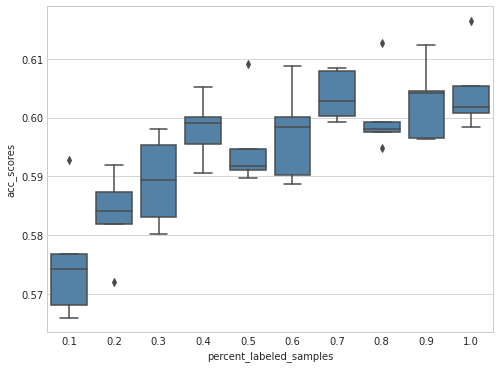

In [25]:
plt.figure(figsize=(8,6))
sns.boxplot(data=dataset_report, x="percent_labeled_samples", y="acc_scores", color="steelblue")

In [26]:
dataset_report.to_csv("trip_advisor_hotel_rev.csv", index=False)

In [27]:
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# ax[0].scatter(i_range, acc_scores)
# ax[0].plot(i_range, acc_scores)
# ax[0].set_xlabel("Percent of Labeled Samples")
# ax[0].set_ylabel("Accuracy Score")
# ax[0].set_title("% of Labeled Samples Vs Accuracy Score", fontweight="bold")
# ax[1].scatter(i_range, f1_scores)
# ax[1].plot(i_range, f1_scores)
# ax[1].set_xlabel("Percent of Labeled Samples")
# ax[1].set_ylabel("F1 Score")
# ax[1].set_title("% of Labeled Samples Vs F1 Score", fontweight="bold")
# plt.show()